## **<h4 style='text-align: center; color:red '>Assignment 2</h4>**


**<h3 style='text-align: left; color:red '>Team Info</h3>**
- **Name1:** Khaled Mohamed Mohamed Ahmed

  **ID1:** 20010528

- **Name2:** Mohamed EL-Nady mohamed Gomaa

  **ID2:** 20011513

- **Name3:** Mohamed Aly Hassan Mahmoud

  **ID3:**   20011662

---

# **The Functions**

#### **The liberaries Used**

In [22]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

#### **Read the data**

- **Reading dataset, Dividing it to train and test, assigning labels according to the _activity_**

- **Calculating the mean vectors approach and flattening the data**

In [23]:
# Function for reading data
def read_data(dataset_folder):
    # Initialize lists to store data
    train_mean_vectors = []
    test_mean_vectors = []
    train_flattened_features = []
    test_flattened_features = []
    train_labels = []
    test_labels = []
    # Loop through each activity folder
    for activity_folder in sorted(os.listdir(dataset_folder)):
        activity_path = os.path.join(dataset_folder, activity_folder)
        if os.path.isdir(activity_path):
            activity_label = activity_folder
            # Loop through each subject folder
            for subject_folder in sorted(os.listdir(activity_path)):
                subject_path = os.path.join(activity_path, subject_folder)
                if os.path.isdir(subject_path):
                    # Loop through each segment file
                    segments = sorted(os.listdir(subject_path))
                    for i, segment_file in enumerate(segments):
                        segment_path = os.path.join(subject_path, segment_file)
                        if segment_path.endswith(".txt"):
                            # Read data from the segment file
                            segment_data = np.loadtxt(segment_path, delimiter=",")
                            # Calculate mean for each column
                            mean_vector = np.mean(segment_data, axis=0)
                            flattened_feature = segment_data.flatten()
                            # Decide if the segment is for training or testing
                            if i < 48:
                                train_mean_vectors.append(mean_vector)
                                train_flattened_features.append(flattened_feature)
                                train_labels.append(activity_label)
                            else:
                                test_mean_vectors.append(mean_vector)
                                test_flattened_features.append(flattened_feature)
                                test_labels.append(activity_label)
    # Convert lists to numpy arrays
    train_mean_vectors = np.array(train_mean_vectors)
    test_mean_vectors = np.array(test_mean_vectors)
    train_flattened_features = np.array(train_flattened_features)
    test_flattened_features = np.array(test_flattened_features)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    
    return train_mean_vectors, test_mean_vectors, train_flattened_features, test_flattened_features, train_labels, test_labels

#### **Kmean function for clustring**

In [24]:
#////////////////kmean function//////////////////////////////
def kmeans_np(data, k, max_iters=300, tol=1e-4):
    # Initialize centroids by randomly sampling from data
    centroids = data[np.random.choice(len(data), size=k, replace=False)]
    unique_centroids = np.unique(centroids, axis=0)
    while len(unique_centroids) != k:
            centroids = data[np.random.choice(len(data), size=k, replace=False)]
            unique_centroids = np.unique(centroids, axis=0)
    for _ in range(max_iters):
        # Calculate distances from each data point to each centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        
        # Assign each data point to the closest centroid
        labels = np.argmin(distances, axis=1)
        
        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    
        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        
        centroids = new_centroids
    
    return labels, centroids

**Performing PCA dimensionality reduction on flattened data**

In [25]:
#////////////////Pca for the flattened data//////////////////
def perform_PCA(train_flattened_features):
    pca = PCA(n_components=45)
    train_reduced__flattened_features = pca.fit_transform(train_flattened_features)
    return train_reduced__flattened_features

#### **Normalized cut algorithm**

**Fuction to construct the similarity matrix by k-neightbour way**

In [26]:
#////////////////making the similarity matrix//////////////////
def construct_similarity_graph(data, k_neighbors=80):
    n_samples = len(data)
    similarity_graph = np.zeros((n_samples, n_samples), dtype=float)

    for i in range(n_samples):
        distances = np.linalg.norm(data - data[i], axis=1)
        indices = np.argsort(distances)[:k_neighbors+1]  # Include each point as its own neighbor
        similarity_graph[i, indices[1:]] = 1

    similarity_graph = (similarity_graph + similarity_graph.T) > 0  # Make the graph undirected
    return similarity_graph

**Normalized cut algorithm for clusrtring**

In [27]:
#////////////////N-cut function////////////////////////////////
def kways_normalized_cut(data, K=19):
    similarity_graph = construct_similarity_graph(data)
    
    degree_matrix = np.diag(np.sum(similarity_graph, axis=1))
    laplacian_matrix = degree_matrix - similarity_graph
    laplacian_matrix = np.linalg.inv(degree_matrix).dot(laplacian_matrix)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix)
    sorted_indices = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    U = normalize(eigenvectors)
    Y = U[:, :K]
    kmeans = KMeans(n_clusters=K, random_state=42).fit(Y)
    #labels, centroids = kmeans_np(Y,K)
    return kmeans.labels_

#### **DBSCAN clustering algorithm implementation**

In [28]:
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def range_query(data, point_index, eps, distance_fn):
    neighbors = []
    for i, point in enumerate(data):
        if i != point_index and distance_fn(data[point_index], point) <= eps:
            neighbors.append(i)
    return neighbors

def dbscan(data, eps, min_pts, distance_fn=euclidean_distance):
    labels = np.zeros(len(data), dtype=int)  # Initialize labels with zeros (noise labeled as 0)
    cluster_id = 0

    for i, point in enumerate(data):
        if labels[i] != 0:  # Skip points already processed or assigned to a cluster
            continue

        neighbors = range_query(data, i, eps, distance_fn)

        if len(neighbors) < min_pts:  # Mark point as noise if it doesn't have enough neighbors
            labels[i] = 0
            continue

        cluster_id += 1
        labels[i] = cluster_id

        for neighbor in neighbors:
            if labels[neighbor] == 0:  # Process unprocessed neighbors
                labels[neighbor] = cluster_id

            if labels[neighbor] != 0:  # Skip points already assigned to a cluster
                continue

            sub_neighbors = range_query(data, neighbor, eps, distance_fn)

            if len(sub_neighbors) >= min_pts:  # Expand cluster if neighbor is core point
                neighbors.extend(sub_neighbors)

    return labels

**Grid search to find the best parameters for DBSCAN according to best _sillhouette score_**

In [29]:
def grid_search_dbscan(data, eps_range, min_pts_range):
    best_score = -1
    best_eps = None
    best_min_pts = None

    for eps in eps_range:
        for min_pts in min_pts_range:
            labels = dbscan(data, eps, min_pts)
            score = silhouette_score(data, labels)
            print("grid search loop")
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_pts = min_pts
    print(f"best eps:{best_eps} and best min pts{best_min_pts}")
    print("grid search terminated")
    return best_eps, best_min_pts

### **Evaluation Part**

**Function implemented to calculate the entropy to be used in evalution (lesser the better)**

In [30]:
#////////////////Entrophy function////////////////////////////////
def Entropy(clusters, ground_truth):
    n_samples = len(ground_truth)
    n_clusters = len(set(clusters))
    cluster_indices = [np.where(clusters == i)[0] for i in range(n_clusters)]
    cluster_ground_truth = [ground_truth[indices] for indices in cluster_indices]

    entropy_score = 0.0
    for cluster_gt in cluster_ground_truth:
        cluster_size = len(cluster_gt)
        partition_counts = np.zeros(max(ground_truth) + 1)  # Initialize counts for each partition
        for partition in cluster_gt:
            partition_counts[partition] += 1
        partition_probabilities = partition_counts / cluster_size
        partition_probabilities[partition_probabilities == 0] = 1e-10  # Replace zero probabilities with a small epsilon
        cluster_entropy = -np.sum(partition_probabilities * np.log2(partition_probabilities))
        entropy_score += (cluster_size / n_samples) * cluster_entropy

    return entropy_score

**Function used to calculate the precision and the recall and the F1 score to evaluate (higher is better)**

In [31]:
def precision_recall_f_measure(clusters, ground_truth):
    cluster_indices = np.unique(clusters)
    num_clusters = len(cluster_indices)
    precision_sum = 0
    recall_sum = 0
    f_measure_sum = 0
    
    for cluster_index in cluster_indices:
        # Find indices of samples in the cluster
        indices = np.where(clusters == cluster_index)[0]

        # Get ground truth labels for the cluster
        cluster_ground_truth = ground_truth[indices]

        # Calculate precision
        cluster_size = len(cluster_ground_truth)
        unique_labels, counts = np.unique(cluster_ground_truth, return_counts=True)
        majority_label_count = np.max(counts) if len(counts) > 0 else 0
        preci = majority_label_count / cluster_size if cluster_size > 0 else 0
        precision_sum += preci

        # Calculate recall
        majority_label = unique_labels[np.argmax(counts)] if len(unique_labels) > 0 else None
        mji = np.sum(ground_truth == majority_label)
        recalli = majority_label_count / mji if mji > 0 else 0
        recall_sum += recalli

        # Calculate F-measure
        f_measure = 2 * preci * recalli / (preci + recalli) if (preci + recalli) > 0 else 0
        f_measure_sum += f_measure

    # Calculate mean precision, recall, and F-measure
    precision = precision_sum / num_clusters
    recall = recall_sum / num_clusters
    f_measure = f_measure_sum / num_clusters

    return precision, recall, f_measure

**Function to call the evaluations methods**

In [32]:
#///////////////////////////Evaluation/////////////////////////////
def Evaluation(clusters, ground_truth):
    conditional_entrophy = Entropy(clusters,ground_truth)
    precision, recall, f_measure = precision_recall_f_measure(clusters, ground_truth)
    return precision, recall, f_measure , conditional_entrophy

**Function used to convert the labels to numeric**

In [33]:
#////////////////function to convert labels letters to numbers to can verify////////////////////////////////
def convert_labels_to_numeric(labels):
    # Create a dictionary to map class names to numerical labels
    label_map = {}
    numeric_labels = []
    count = 0

    # Iterate over the test labels
    for label in labels:
        # Check if the label is already in the mapping dictionary
        if label not in label_map:
            # If not, assign it a new numerical label
            label_map[label] = count
            count += 1
        # Append the numerical label to the list
        numeric_labels.append(label_map[label])
    
    return numeric_labels

**Function to print the evaluation measures**

In [34]:
#////////////////function to print all evalutions////////////////////////////////
def print_eval(entrophy=0,precision=0,recall=0,f_measure=0,symbol=""):
    print(f"Evaluation for {symbol}:")
    print(f"(Precision:{precision}) , (Recall:{recall}) , (F1-score:{f_measure}) , (Entropy:{entrophy})")
    print()

# **Start Main**

#### **Getting the data ready for the clustring**

In [35]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~Main~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Folder containing the dataset
dataset_folder = 'daily+and+sports+activities\data'
k_values = [8, 13, 19, 28, 38]
# Read data
train_mean_vectors, test_mean_vectors, train_flattened_features, test_flattened_features, train_labels, test_labels = read_data(dataset_folder)
# Perform PCA for dimensionality reduction
train_reduced_flattened_features = perform_PCA(train_flattened_features)
test_reduced_flattened_features = perform_PCA(test_flattened_features)

# Specify the K values to be used
k_values = [8, 13, 19, 28, 38]
test_labels = np.array(convert_labels_to_numeric(test_labels))
train_labels = np.array(convert_labels_to_numeric(train_labels))
# Perform K-Means clustering for each K value using mean vectors

#### **Making clustring on the training data using three algorithm**

- **Kmean clustring on k = {8, 13, 19, 28, 38} on mean vector and flatten data and collect the evaluation of train set**

In [36]:
# ###########################Train Set##########################
print("######################Train set#################################")
print()
print("--------------Clustering using Kmeans --> mean vectors--------------------")
for k in k_values:
    K_labels1, centroids = kmeans_np(train_mean_vectors, k)
    print(f"Cluster labels for K={k}:")
    print(f"unique labels :{len(np.unique(K_labels1, axis=0))}")
    print(K_labels1)
    print()
    precision_K1,recall_K1, f_measure_K1,entrophy_K1 = Evaluation(K_labels1 , train_labels)
    print_eval(entrophy_K1,precision_K1,recall_K1, f_measure_K1,"Kmeans_K1")
K_labels1, centroids = kmeans_np(train_mean_vectors, 19)
precision_K1,recall_K1, f_measure_K1,entrophy_K1 = Evaluation(K_labels1 , train_labels)
# Perform K-Means clustering for each K value using flatten features with using PCA
print("-------------Clustering using Kmeans --> flatten features with using PCA-------------")
for k in k_values:
    K_labels2, centroids = kmeans_np(train_reduced_flattened_features, k)
    print(f"Cluster labels for K={k}:")
    print(f"unique labels :{len(np.unique(K_labels2, axis=0))}")
    print(K_labels2)
    print()
    precision_K2,recall_K2, f_measure_K2,entrophy_K2 = Evaluation(K_labels2 , train_labels)
    print_eval(entrophy_K2,precision_K2,recall_K2, f_measure_K2,"Kmeans_K2")
K_labels2, centroids = kmeans_np(train_reduced_flattened_features, 19)
precision_K2,recall_K2, f_measure_K2,entrophy_K2 = Evaluation(K_labels2 , train_labels)
    

######################Train set#################################

--------------Clustering using Kmeans --> mean vectors--------------------
Cluster labels for K=8:
unique labels :8
[7 7 7 ... 6 6 0]

Evaluation for Kmeans_K1:
(Precision:0.5638419486863786) , (Recall:0.7613932291666667) , (F1-score:0.5575149565580718) , (Entropy:2.5118542564607194)

Cluster labels for K=13:
unique labels :13
[6 6 6 ... 3 4 5]

Evaluation for Kmeans_K1:
(Precision:0.5340920464476415) , (Recall:0.6362179487179488) , (F1-score:0.5428892211852374) , (Entropy:2.068758154899203)

Cluster labels for K=19:
unique labels :19
[14 14 14 ... 17  3  8]

Evaluation for Kmeans_K1:
(Precision:0.505095673497104) , (Recall:0.4102247807017544) , (F1-score:0.39852929222588307) , (Entropy:2.0780735774134187)

Cluster labels for K=28:
unique labels :28
[16 16 16 ... 17 17 22]

Evaluation for Kmeans_K1:
(Precision:0.6676279832065806) , (Recall:0.3311011904761905) , (F1-score:0.38775645028942174) , (Entropy:1.8229115975630263

- **Kway N-cut clustring on k = 19 on mean vector and flatten data and collect the evaluation of train set**

In [37]:
# Perform N-cut algorithm for k=19 using mean vectors
print("----------------Clustering using N-cut --> mean vectors---------------")
N_labels1 = kways_normalized_cut(train_mean_vectors)
print(f"Cluster labels for K=19:")
print(f"unique labels :{len(np.unique(N_labels1, axis=0))}")
print(N_labels1)
print()
#Evaluation
precision_N1,recall_N1, f_measure_N1,entrophy_N1 = Evaluation(N_labels1 , train_labels)

# # Perform N-cut algorithm for k=19 using flatten features with using PCA
print("----------------Clustering using N-cut --> flatten features with using PCA---------------")
N_labels2 = kways_normalized_cut(train_reduced_flattened_features)
print("Cluster labels for K=19:")
print(f"unique labels :{len(np.unique(N_labels2, axis=0))}" )
print(N_labels2)
print()
#Evaluation
precision_N2,recall_N2, f_measure_N2,entrophy_N2 = Evaluation(N_labels2 , train_labels)

----------------Clustering using N-cut --> mean vectors---------------
Cluster labels for K=19:
unique labels :19
[6 6 6 ... 0 5 0]

----------------Clustering using N-cut --> flatten features with using PCA---------------
Cluster labels for K=19:
unique labels :19
[18 18 18 ...  9  9  3]



- **DBSCAN clustring on k = 19 on mean vector and flatten data and collect the evaluation of train set**

In [38]:
# Perform DBSCAN algorithm using mean_vectors
print("----------------Clustering using DBSCAN --> mean_vectors---------------")
D_labels1 = dbscan(train_mean_vectors,1.5,5)
print("Cluster labels:")
print(f"unique labels :{len(np.unique(D_labels1, axis=0))}" )
print(D_labels1)
print()
#Evaluation
precision_D1,recall_D1, f_measure_D1,entrophy_D1 = Evaluation(D_labels1 , train_labels)

# Perform DBSCAN algorithm using flatten features with using PCA
print("----------------Clustering using DBSCAN --> flatten features with using PCA---------------")
D_labels2 = dbscan(train_reduced_flattened_features,4,37)
print("Cluster labels:")
print(f"unique labels :{len(np.unique(D_labels2, axis=0))}" )
print(D_labels2)
print()
#Evaluation
precision_D2,recall_D2, f_measure_D2,entrophy_D2 = Evaluation(D_labels2 , train_labels)

----------------Clustering using DBSCAN --> mean_vectors---------------
Cluster labels:
unique labels :472
[1 1 1 ... 0 0 0]

----------------Clustering using DBSCAN --> flatten features with using PCA---------------
Cluster labels:
unique labels :18
[0 0 0 ... 0 0 0]



- **print the evaluation results of train set**

In [39]:
print_eval(entrophy_K1,precision_K1,recall_K1, f_measure_K1,"Kmeans_K1")
print_eval(entrophy_K2,precision_K2,recall_K2, f_measure_K2,"Kmeans_K2")
print_eval(entrophy_N1,precision_N1,recall_N1, f_measure_N1,"N-cut_N1")
print_eval(entrophy_N2,precision_N2,recall_N2, f_measure_N2,"N-cut_N2")
print_eval(entrophy_D1,precision_D1,recall_D1, f_measure_D1,"DBSCAN_1")
print_eval(entrophy_D2,precision_D2,recall_D2, f_measure_D2,"DBSCAN_2")
###########################end of train set######################################

Evaluation for Kmeans_K1:
(Precision:0.575664162131431) , (Recall:0.4823190789473684) , (F1-score:0.46695937665106263) , (Entropy:1.9192127716069742)

Evaluation for Kmeans_K2:
(Precision:0.6740307354265782) , (Recall:0.5052083333333334) , (F1-score:0.49395625350864264) , (Entropy:1.8475238882834464)

Evaluation for N-cut_N1:
(Precision:0.6537057373535169) , (Recall:0.4385964912280701) , (F1-score:0.4670446385628755) , (Entropy:2.1673918733643296)

Evaluation for N-cut_N2:
(Precision:0.6312450809086224) , (Recall:0.44229714912280704) , (F1-score:0.46107077159757187) , (Entropy:2.1303239556081275)

Evaluation for DBSCAN_1:
(Precision:0.9948673862747873) , (Recall:0.03497969632768358) , (F1-score:0.06258103481925495) , (Entropy:0.5851833665717134)

Evaluation for DBSCAN_2:
(Precision:0.9476148016049932) , (Recall:0.13758680555555552) , (F1-score:0.1539285859011811) , (Entropy:3.8874284178463507)



#### **Making clustring on the test data using three algorithm**

- **Kmean clustring on k = {8, 13, 19, 28, 38} on mean vector and flatten data and collect the evaluation of test set**

In [44]:
######################test set#################################
print("###################### Test set #################################")
print()
print("--------------Clustering using Kmeans --> mean vectors--------------------")
for k in k_values:
    K_labels1, centroids = kmeans_np(test_mean_vectors, k)
    print(f"Cluster labels for K={k}:")
    print(f"unique labels :{len(np.unique(K_labels1, axis=0))}")
    print(K_labels1)
    print()
#Evaluation
    precision_K1,recall_K1, f_measure_K1,entrophy_K1 = Evaluation(K_labels1 , test_labels)
    print_eval(entrophy_K1,precision_K1,recall_K1, f_measure_K1,"Kmeans_1")
K_labels1, centroids = kmeans_np(test_mean_vectors, 19)
precision_K1,recall_K1, f_measure_K1,entrophy_K1 = Evaluation(K_labels1 , test_labels)
# Perform K-Means clustering for each K value using flatten features with using PCA
print("-------------Clustering using Kmeans --> flatten features with using PCA-------------")
for k in k_values:
    K_labels2, centroids = kmeans_np(test_reduced_flattened_features, k)
    print(f"Cluster labels for K={k}:")
    print(f"unique labels :{len(np.unique(K_labels2, axis=0))}")
    print(K_labels2)
    print()
#Evaluation
    precision_K2,recall_K2, f_measure_K2,entrophy_K2 = Evaluation(K_labels2 , test_labels)
    print_eval(entrophy_K2,precision_K2,recall_K2, f_measure_K2,"Kmeans_2")
K_labels2, centroids = kmeans_np(test_reduced_flattened_features, 19)
precision_K2,recall_K2, f_measure_K2,entrophy_K2 = Evaluation(K_labels2 , test_labels)

###################### Test set #################################

--------------Clustering using Kmeans --> mean vectors--------------------
Cluster labels for K=8:
unique labels :8
[3 3 3 ... 7 7 7]

Evaluation for Kmeans_1:
(Precision:0.3629376498595574) , (Recall:0.65234375) , (F1-score:0.40801603254817315) , (Entropy:2.5671860049933612)

Cluster labels for K=13:
unique labels :13
[10 10 10 ...  1  1  1]

Evaluation for Kmeans_1:
(Precision:0.5260297784805549) , (Recall:0.6394230769230769) , (F1-score:0.545865462902639) , (Entropy:2.072674640630969)

Cluster labels for K=19:
unique labels :19
[15 15 15 ...  9  9  9]

Evaluation for Kmeans_1:
(Precision:0.5974155669213266) , (Recall:0.45175438596491224) , (F1-score:0.42666131163185655) , (Entropy:1.9307524730158145)

Cluster labels for K=28:
unique labels :28
[13 13 13 ...  1  1  1]

Evaluation for Kmeans_1:
(Precision:0.6393693509289341) , (Recall:0.36867559523809523) , (F1-score:0.43764459747730733) , (Entropy:1.5817745851549443)


- **Kway N-cut clustring on k = 19 on mean vector and flatten data and collect the evaluation of test set**

In [41]:
# Perform N-cut algorithm for k=19 using mean vectors
print("----------------Clustering using N-cut --> mean vectors---------------")
N_labels1 = kways_normalized_cut(test_mean_vectors)
print(f"Cluster labels for K=19:")
print(f"unique labels :{len(np.unique(N_labels1, axis=0))}")
print(N_labels1)
print()
#Evaluation
precision_N1,recall_N1, f_measure_N1,entrophy_N1 = Evaluation(N_labels1 , test_labels)

# Perform N-cut algorithm for k=19 using flatten features with using PCA
print("----------------Clustering using N-cut --> flatten features with using PCA---------------")
N_labels2 = kways_normalized_cut(test_reduced_flattened_features)
print("Cluster labels for K=19:")
print(f"unique labels :{len(np.unique(N_labels2, axis=0))}" )
print(N_labels2)
print()
#Evaluation
precision_N2,recall_N2, f_measure_N2,entrophy_N2 = Evaluation(N_labels2 , test_labels)

----------------Clustering using N-cut --> mean vectors---------------
Cluster labels for K=19:
unique labels :19
[11 11 11 ... 16 16 16]

----------------Clustering using N-cut --> flatten features with using PCA---------------
Cluster labels for K=19:
unique labels :19
[ 8  8  8 ... 15 15 15]



- **DBSCAN clustring on k = 19 on mean vector and flatten data and collect the evaluation of test set**

In [42]:
# Perform DBSCAN algorithm using mean_vectors
print("----------------Clustering using DBSCAN --> mean_vectors---------------")
D_labels1 = dbscan(test_mean_vectors,0.1,9)
print("Cluster labels:")
print(f"unique labels :{len(np.unique(D_labels1, axis=0))}" )
print(D_labels1)
print()
#Evaluation
precision_D1,recall_D1, f_measure_D1,entrophy_D1 = Evaluation(D_labels1 , test_labels)

# Perform DBSCAN algorithm using flatten features with using PCA
print("----------------Clustering using DBSCAN --> flatten features with using PCA---------------")
D_labels2 = dbscan(test_reduced_flattened_features,3,11)
print("Cluster labels:")
print(f"unique labels :{len(np.unique(D_labels2, axis=0))}" )
print(D_labels2)
print()
# Evaluation
precision_D2,recall_D2, f_measure_D2,entrophy_D2 = Evaluation(D_labels2 , test_labels)

----------------Clustering using DBSCAN --> mean_vectors---------------
Cluster labels:
unique labels :19
[0 0 0 ... 0 0 0]

----------------Clustering using DBSCAN --> flatten features with using PCA---------------
Cluster labels:
unique labels :20
[1 1 1 ... 0 0 0]



- **print the evaluation results of test set**

In [45]:
# print the evaluation
print_eval(entrophy_K1,precision_K1,recall_K1, f_measure_K1,"Kmeans_1")
print_eval(entrophy_K2,precision_K2,recall_K2, f_measure_K2,"Kmeans_2")
print_eval(entrophy_N1,precision_N1,recall_N1, f_measure_N1,"N-cut_1")
print_eval(entrophy_N2,precision_N2,recall_N2, f_measure_N2,"N-cut_2")
print_eval(entrophy_D1,precision_D1,recall_D1, f_measure_D1,"DBSCAN_1")
print_eval(entrophy_D2,precision_D2,recall_D2, f_measure_D2,"DBSCAN_2")
###########################end of test set#####################################

Evaluation for Kmeans_1:
(Precision:0.5813862346295141) , (Recall:0.47368421052631576) , (F1-score:0.4746247942551629) , (Entropy:1.8794018795884078)

Evaluation for Kmeans_2:
(Precision:0.718053970485348) , (Recall:0.46381578947368424) , (F1-score:0.4524245213067192) , (Entropy:1.9437960991296688)

Evaluation for N-cut_1:
(Precision:0.5267982912147551) , (Recall:0.5202850877192983) , (F1-score:0.5143769688415023) , (Entropy:1.7024882224756412)

Evaluation for N-cut_2:
(Precision:0.4905853300964837) , (Recall:0.4720394736842105) , (F1-score:0.46951631598127064) , (Entropy:1.905850733061385)

Evaluation for DBSCAN_1:
(Precision:0.9504066841788777) , (Recall:0.14089912280701755) , (F1-score:0.16450393073253378) , (Entropy:3.8295050337378544)

Evaluation for DBSCAN_2:
(Precision:0.9530075187969924) , (Recall:0.16875) , (F1-score:0.2167848699763594) , (Entropy:3.640348783217787)



# **Comparison**

![Screenshot 2024-03-27 180734.png](<attachment:Screenshot 2024-03-27 180734.png>)
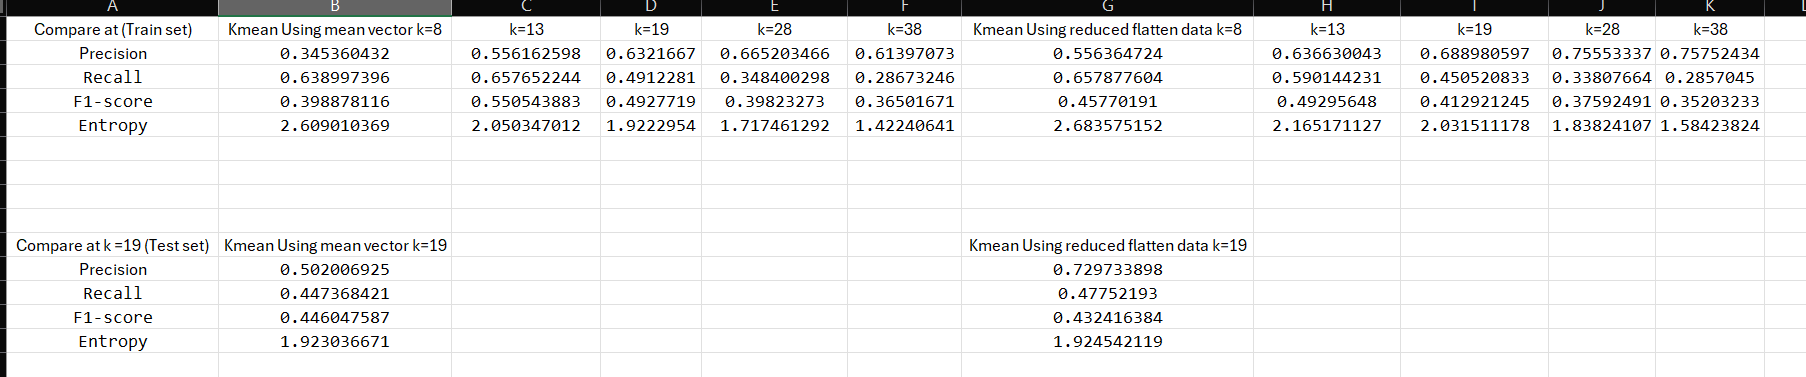

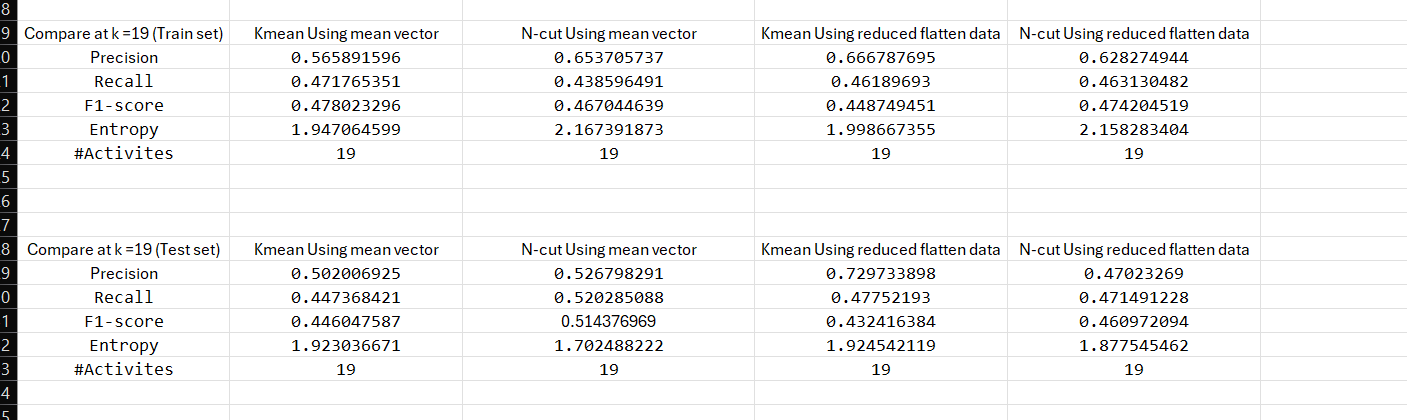

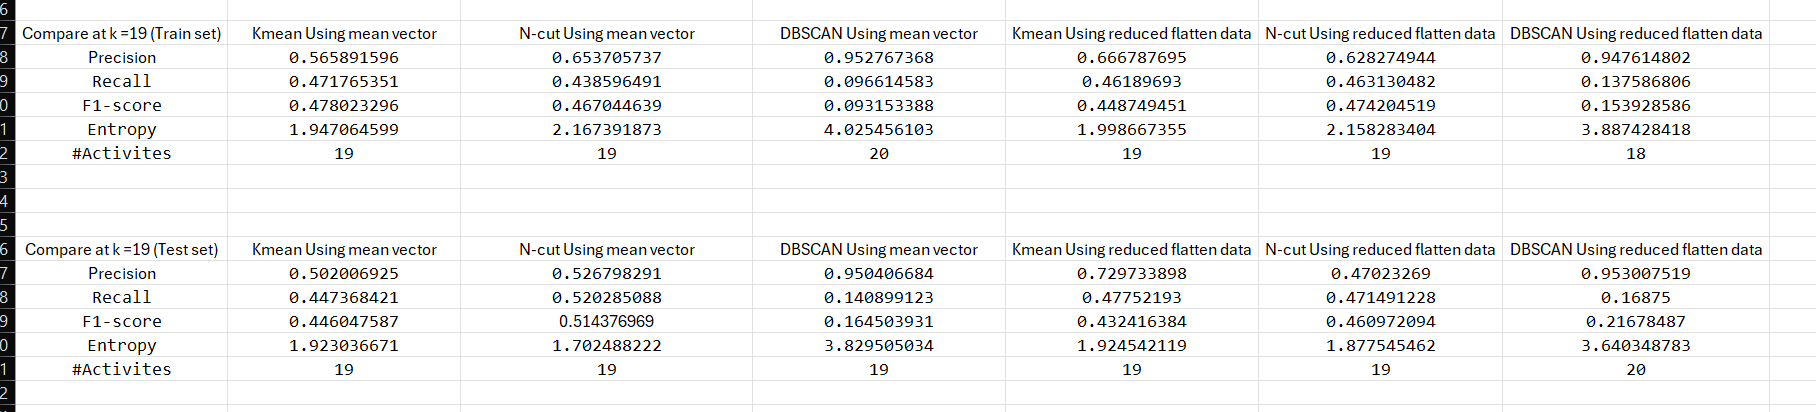

# **The End**